In [1]:
import jax.numpy as jnp
import b3d
import os
import trimesh
import matplotlib.pyplot as plt
import jax

In [2]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

/opt/conda/envs/b3d/lib/python3.10/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [3]:
print("Number of vertices: ", object_library.vertices.shape[0])


Number of vertices:  10689


In [4]:
# def beta_logpdf(obs_image, rendered_image, multiplier, outlier_prob):
#     distances = jnp.abs(obs_image - rendered_image)
#     probabilities = jax.scipy.stats.beta.logpdf(
#         obs_image, 1 + rendered_image * multiplier, 1 + (1.0 - rendered_image) *  multiplier
#     )
#     probabilities_adjusted = jnp.logaddexp(
#         probabilities + jnp.log(1.0 - outlier_prob),
#         jnp.log(outlier_prob)
#     )
#     return probabilities_adjusted.sum()

# def beta_sample(key, rendered_image, multiplier, outlier_prob):
#     return jax.random.beta(
#         key, 1 + rendered_image * multiplier, 1 + (1.0 - rendered_image) *  multiplier, shape=rendered_image.shape
#     )


def gaussian_logpdf(obs_image, rendered_image,b, multiplier, a, outlier_prob):
    probabilities = jax.scipy.stats.norm.logpdf(
        obs_image, rendered_image, multiplier
    )
    probabilities_adjusted = jnp.logaddexp(
        probabilities + jnp.log(1.0 - outlier_prob),
        jnp.log(outlier_prob)
    )
    return probabilities_adjusted.sum()

def gaussian_sample(key, rendered_image, b,multiplier, a, outlier_prob):
    return jax.random.normal(
        key, shape=rendered_image.shape
    ) * multiplier + rendered_image


def new_logpdf(observed_rgb, rendered_rgb, rendered_depth, multiplier, color_tolerance, outlier_prob):
    observed_lab = b3d.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.rgb_to_lab(rendered_rgb)
    error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (error < color_tolerance) * valid_data_mask
    inliers = color_inliers
    outliers = jnp.logical_not(inliers) * valid_data_mask
    undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)

    corrected_depth = rendered_depth + (rendered_depth == 0.0) * 1.0
    areas = (corrected_depth / fx) * (corrected_depth / fy)

    inlier_score = 4.0
    return jnp.log(
        # This is leaving out a 1/A (which does depend upon the scene)
        inlier_score * jnp.sum(inliers * areas) +
        1.0 * jnp.sum(undecided * areas)  +
        outlier_prob * jnp.sum(outliers * areas)
    ) * multiplier

pose_from_x = lambda x: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -0.3, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation(jnp.array([x, 0.0, 0.0]))
N = 500
scanned_x_value = jnp.linspace(-0.01, 0.01, N)
poses = jax.vmap(pose_from_x)(scanned_x_value)
transformed_vertices = jax.vmap(lambda i: poses[i].apply(object_library.vertices))(jnp.arange(len(poses)))

In [5]:
h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in [1, 3, 5, 7, 9]
]

In [6]:
def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        transformed_vertices,
        object_library.faces,
        jnp.concatenate([attributes, transformed_vertices[...,-1:]],axis=-1)
    )

(150, 150, 4)


(-0.5, 149.5, 149.5, -0.5)

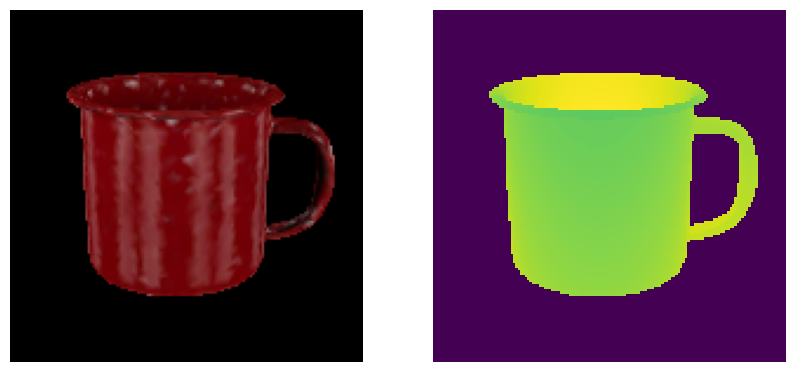

In [8]:
all_images = [
        render_rgbd_many(r,
        transformed_vertices,
        object_library.faces,
        jnp.tile(object_library.attributes, (N,1,1)),
    )
    for r in renderers
]
images = all_images[1]
gt_image = images[N//2]
print(gt_image.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Display the first image in the first subplot
ax1.imshow(gt_image[...,:3])
ax1.axis('off')  # Hide the axis

# Display the second image in the second subplot
ax2.matshow(gt_image[...,3])
ax2.axis('off')  # Hide the axis


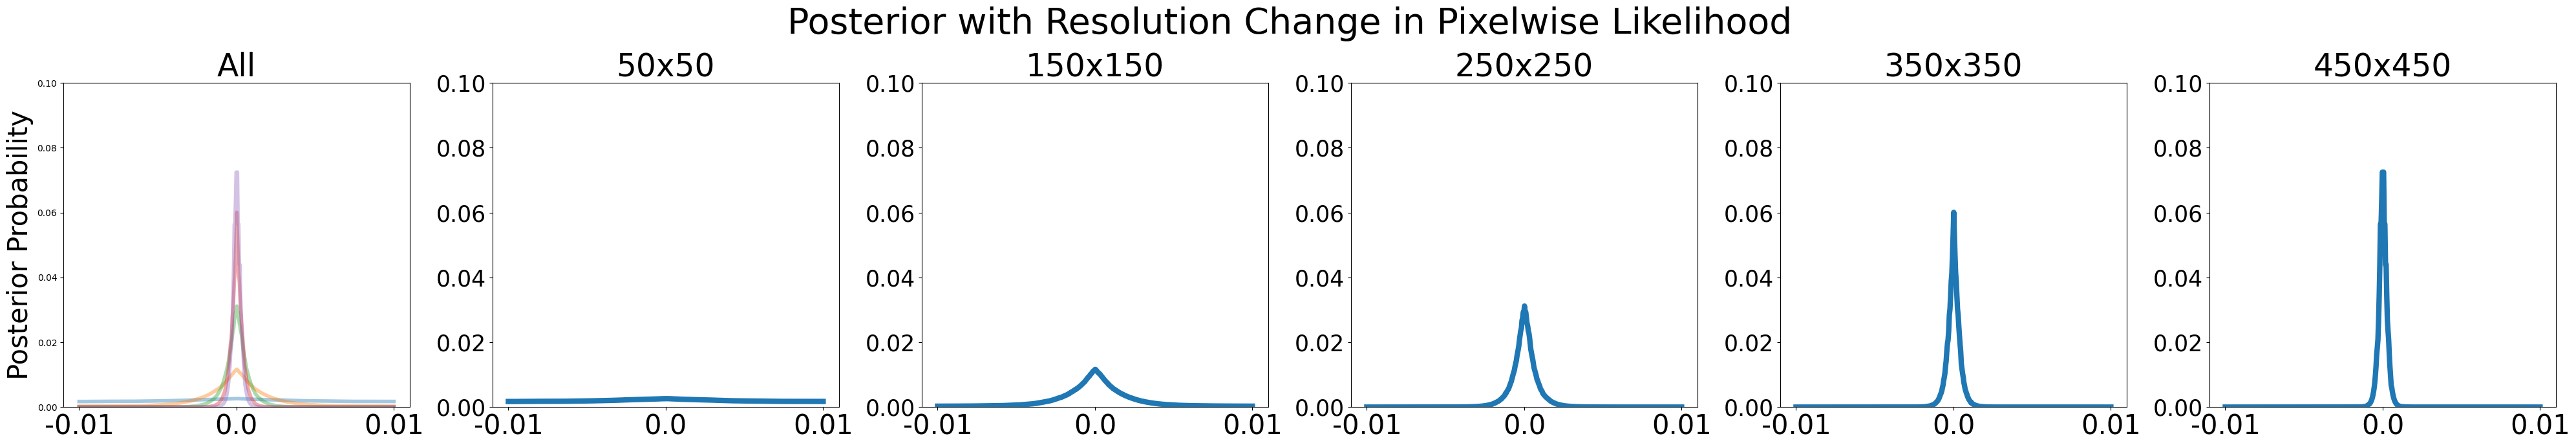

In [10]:
fig, axes = plt.subplots(1, len(renderers) + 1, figsize=(40, 7))
title = None
for IDX in range(len(renderers)):
    
    r = renderers[IDX]
    images = all_images[IDX]
    gt_image = images[N // 2][...,:3]
    
    # multiplier = 1000.0
    # variance = 60.0
    # outlier_prob = 0.05
    # logpdfs = jax.vmap(new_logpdf, in_axes=(None, 0, 0, None, None, None))(gt_image,
    #                                                                        images[...,:3], images[...,3], multiplier, variance, outlier_prob)
    # title = "Posterior with Resolution Change in Surface-Ray-Likelihood"
    
    multiplier = 6.0
    variance = 50.0
    outlier_prob =  0.1
    
    logpdfs = jax.vmap(gaussian_logpdf, in_axes=(None, 0, 0, None, None, None))(gt_image,
                                                                           images[...,:3], images[...,3], multiplier, variance, outlier_prob)
    title = "Posterior with Resolution Change in Pixelwise Likelihood"
    
    axes[0].plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=0.4, label=f"{r.height}x{r.width}", linewidth=4)
    axes[IDX+1].plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=1.0, label=f"{r.height}x{r.width}", linewidth=6)
    axes[IDX+1].set_ylim(0.0, 0.1)
    axes[IDX+1].set_xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
    axes[IDX+1].set_xticklabels([scanned_x_value.min(), 0.0, scanned_x_value.max()], fontsize=30)
    axes[IDX+1].set_title(f"{r.height}x{r.width}", fontsize=35)
    axes[IDX+1].tick_params(axis='y', labelsize=25)
    
axes[0].set_ylim(0.0, 0.1)
axes[0].set_xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
axes[0].set_xticklabels([scanned_x_value.min(), 0.0, scanned_x_value.max()], fontsize=30)
axes[0].set_title(f"All", fontsize=35)

# axes[0]([scanned_x_value.min(), 0.0, scanned_x_value.max()])
axes[0].set_ylabel("Posterior Probability", fontsize=30)
# plt.xlabel("X coordinate", fontsize=22)
plt.suptitle(title, fontsize=40) 
plt.tight_layout()

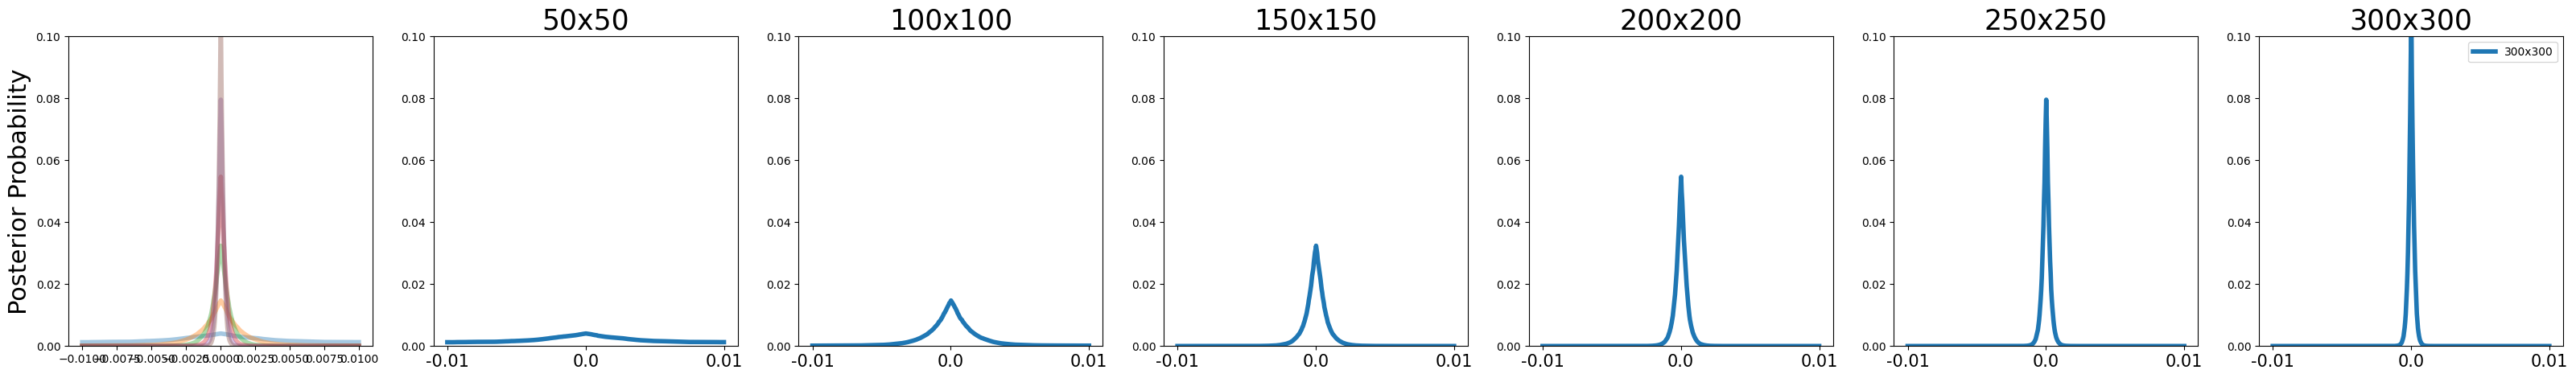

In [122]:
fig, axes = plt.subplots(1, len(renderers) + 1, figsize=(40, 9))

for IDX in range(len(renderers)):
    
    r = renderers[IDX]
    images = all_images[IDX]
    gt_image = images[N // 2][...,:3]
    multiplier = 4.0
    variance = 50.0
    outlier_prob =  0.1
    
    logpdfs = jax.vmap(gaussian_logpdf, in_axes=(None, 0, 0, None, None, None))(gt_image,
                                                                           images[...,:3], images[...,3], multiplier, variance, outlier_prob)
    axes[0].plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=0.4, label=f"{r.height}x{r.width}", linewidth=4)
    axes[IDX+1].plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=1.0, label=f"{r.height}x{r.width}", linewidth=4)
    axes[0].set_ylim(0.0, 0.1)
    axes[IDX+1].set_ylim(0.0, 0.1)
    axes[IDX+1].set_xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
    axes[IDX+1].set_xticklabels([scanned_x_value.min(), 0.0, scanned_x_value.max()], fontsize=15)
    axes[IDX+1].set_title(f"{r.height}x{r.width}", fontsize=25)

axes[0].set_ylim(0.0, 0.1)
axes[0].set_xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
axes[0].set_xticklabels([scanned_x_value.min(), 0.0, scanned_x_value.max()], fontsize=30)
axes[0].set_title(f"{r.height}x{r.width}", fontsize=25)

# axes[0]([scanned_x_value.min(), 0.0, scanned_x_value.max()])
axes[0].set_ylabel("Posterior Probability", fontsize=22)
plt.suptitle("Posterior with Resolution Change in Pixel-wise Likelihood", fontsize=45) 

plt.legend()

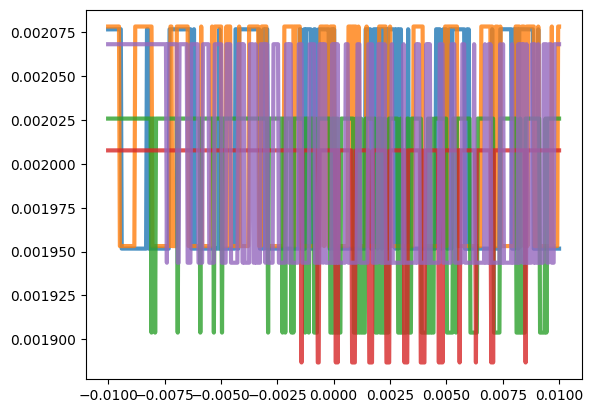

In [21]:
for IDX in range(len(renderers)):
    r = renderers[IDX]
    images = all_images[IDX]
    gt_image = images[N // 2][...,:3]
    multiplier = 0.01
    outlier_prob = 0.01
    logpdfs = jax.vmap(new_logpdf, in_axes=(None, 0, 0, None, None))(gt_image, images[...,:3], images[...,3], multiplier, outlier_prob)
    plt.plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=0.8, label=f"{r.height}x{r.width}", linewidth=3)


In [27]:
T = N // 2
for IDX in range(len(renderers)):
    image = all_images[IDX][T]
    renderer = renderers[IDX]
    print(((image[...,3] / renderer.fx) * (image[...,3] / renderer.fy)).sum())

0.0073542465
0.007341906
0.007319146
0.007322045
0.007338985


In [ ]:
likelihoods = [
    (beta_logpdf, beta_sample, 0.000001, 0.1),
    (gaussian_logpdf, gaussian_sample, 4.0, 0.1)
]

all_samples = [] 
likelihood_index = 1
for renderer in renderers:
    images = renderer.render_many(
        transformed_vertices,
        object_library.faces,
        object_library.attributes,
    )
    gt_image = images[N//2]
    print(gt_image.shape)
    
    logpdf_func, sample_func, multiplier, outlier_prob = likelihoods[likelihood_index]
    
    logpdfs = jax.vmap(logpdf_func, in_axes=(None, 0, None, None))(gt_image, images, multiplier, outlier_prob)
    samples = jax.random.categorical(jax.random.PRNGKey(10), logpdfs, shape=(100,))
    # print(samples)
    all_samples.append(b3d.normalize_log_scores(logpdfs))

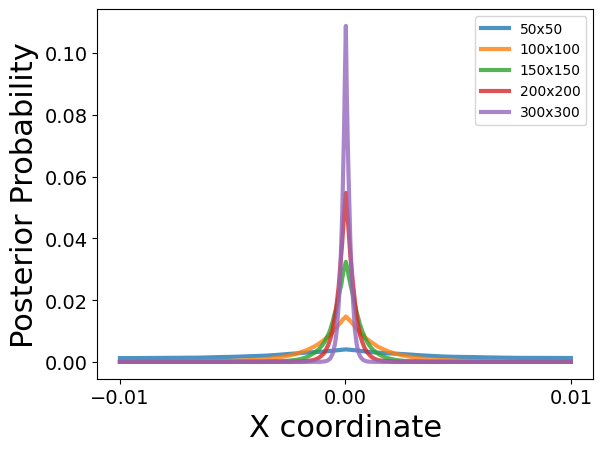

In [75]:
for (r, s) in zip(renderers,all_samples):
    plt.plot(scanned_x_value, s, alpha=0.8, label=f"{r.height}x{r.width}", linewidth=3)
    plt.xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])

plt.ylabel("Posterior Probability", fontsize=22)
plt.xlabel("X coordinate", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

2024-06-13 17:02:54.155169: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1589] failed to free device memory at 0x7ff5cadba400; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2024-06-13 17:02:54.155207: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1589] failed to free device memory at 0x7ff3ce000000; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2024-06-13 17:02:54.155212: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1589] failed to free device memory at 0x7fedce000000; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
E0613 17:02:54.155228  679739 pjrt_stream_executor_client.cc:2826] Execution of replica 0 failed: INTERNAL: Failed to complete all kernels launched on stream 0x56420efb7360: Could not synchronize CUDA stream: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2024-06-13 17:02:54.553165: E external/xla/xla/stream_executor/cuda/cuda_driver.

XlaRuntimeError: INTERNAL: Failed to complete all kernels launched on stream 0x56420efb7360: Could not synchronize CUDA stream: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

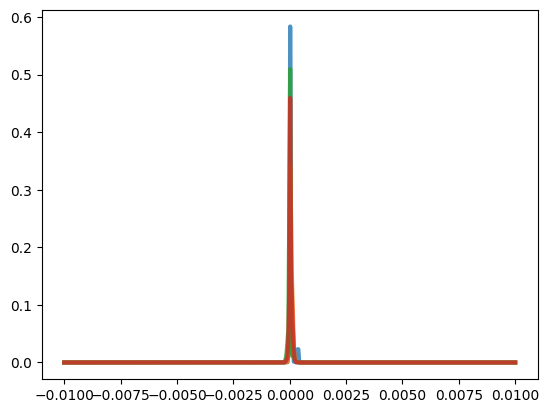

In [26]:
for scale in [1,2,3,4,5]:
    h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
    renderer = b3d.Renderer(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    
    rgb_near, depth_near = renderer.render_attribute_many(
        poses[:,None,...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges,
        object_library.attributes,
    )
    
    color_error, depth_error = (60.0, 0.01)
    inlier_score, outlier_prob = (5.0, 0.00001)
    color_multiplier, depth_multiplier = (5000.0, 500.0)
    model_args = b3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )
    
    observed = (rgb_near[N//2], depth_near[N//2])
    logpdfs = jax.vmap(b3d.rgbd_sensor_model.logpdf, in_axes=(None, 0, 0, None, None, None, None))(
        observed, rgb_near, depth_near, model_args, renderer.fx, renderer.fy, 1.0
    )
    
    plt.plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=0.8, label=f"{renderer.height}x{renderer.width}", linewidth=3)

plt.xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
plt.ylabel("Posterior Probability", fontsize=22)
plt.xlabel("X coordinate", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

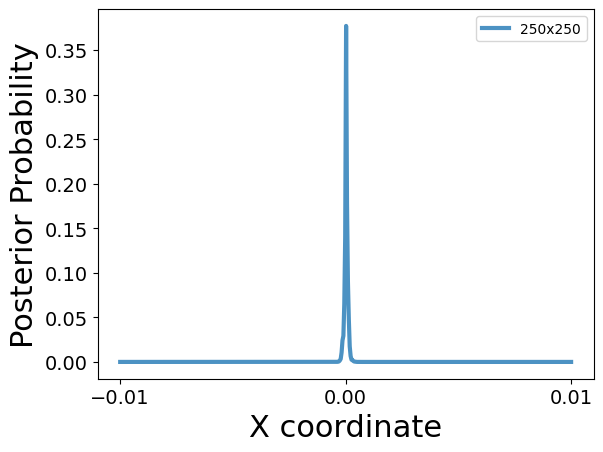

In [25]:
color_error, depth_error = (60.0, 0.01)
inlier_score, outlier_prob = (5.0, 0.00001)
color_multiplier, depth_multiplier = (5000.0, 500.0)
model_args = b3d.ModelArgs(
    color_error,
    depth_error,
    inlier_score,
    outlier_prob,
    color_multiplier,
    depth_multiplier,
)

observed = (rgb_near[N//2], depth_near[N//2])
logpdfs = jax.vmap(b3d.rgbd_sensor_model.logpdf, in_axes=(None, 0, 0, None, None, None, None))(
    observed, rgb_near, depth_near, model_args, renderer.fx, renderer.fy, 1.0
)

plt.plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=0.8, label=f"{renderer.height}x{renderer.width}", linewidth=3)
plt.xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
plt.ylabel("Posterior Probability", fontsize=22)
plt.xlabel("X coordinate", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

In [8]:
poses.shape

(500,)

In [ ]:
def new_sample(self, key, rendered_rgb, rendered_depth, model_args, fx, fy, far):
    return (rendered_rgb, rendered_depth)

def new_logpdf(obs_image, rendered_image, multiplier, outlier_prob):
    undecided = (rendered_image == 0.0).all() * 1.0
    inliers = ((obs_image - rendered_image).sum()) < multiplier
    outliers = (1.0 - inliers) * (1.0 - undecided)
    inliers = inliers * (1.0 - undecided)
    
    corrected_depth = rendered_depth + (rendered_depth == 0.0) * 1.0
    areas = (corrected_depth / fx) * (corrected_depth / fy)

    return jnp.log(
        # This is leaving out a 1/A (which does depend upon the scene)
        inlier_score * jnp.sum(inliers * areas) +
        1.0 * jnp.sum(undecided * areas)  +
        outlier_prob * jnp.sum(outliers * areas)
    ) * multiplier


(200, 200, 3)


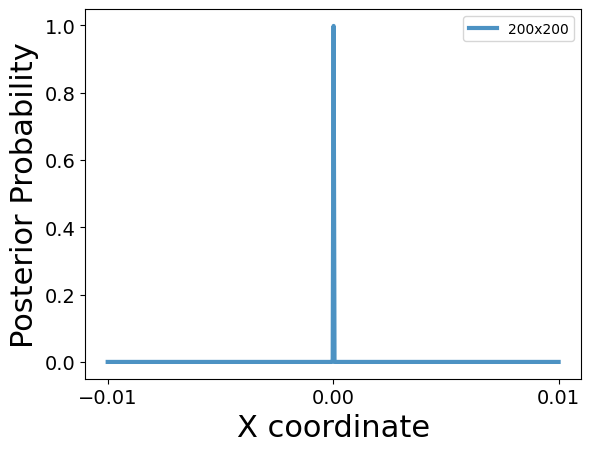

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.134642 2.4704847


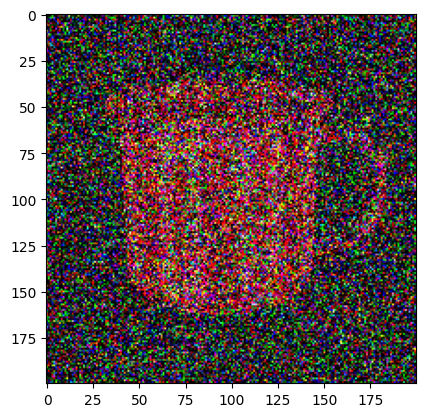

In [72]:
sampled_image = sample_func(jax.random.PRNGKey(10), gt_image, multiplier, outlier_prob)
print(sampled_image.min(), sampled_image.max())
plt.imshow(sampled_image)

-16779.52 9.379881
250
3.238367e-05 0.99999535
[250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250]


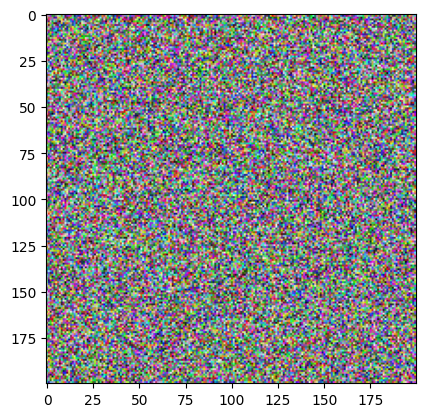

In [84]:
likelihoods = [
    (beta_logpdf, beta_sample, 0.0001, 0.1),
    (gaussian_logpdf, gaussian_sample, 0.4, 0.1)
]

multiplier, outlier_prob = 4.0, 0.1
logpdfs = jax.vmap(independent_beta_noise_likelihood_logpdf, in_axes=(None, 0, None, None))(gt_image, image, multiplier, outlier_prob)
print(logpdfs.min(), logpdfs.max())
print(logpdfs.argmax())

sampled_image = independent_beta_noise_likelihood_sample(jax.random.PRNGKey(10), gt_image, multiplier, outlier_prob)
print(sampled_image.min(), sampled_image.max())
plt.imshow(sampled_image)

print(jax.random.categorical(jax.random.PRNGKey(10), logpdfs, shape=(100,)))

-3759.8804 -285.92972
250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.7077135 2.1578531
[250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 250 250 250 250]


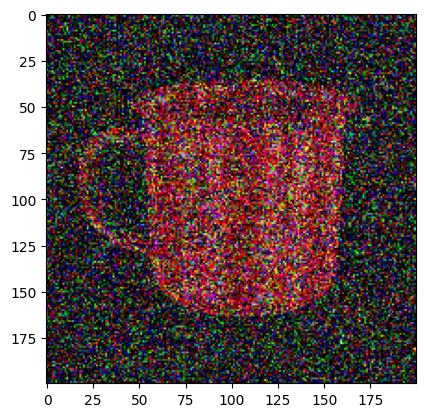

In [85]:

multiplier, outlier_prob = 0.4, 0.1
logpdfs = jax.vmap(independent_gaussian_noise_likelihood_logpdf, in_axes=(None, 0, None, None))(gt_image, image, multiplier, outlier_prob)
print(logpdfs.min(), logpdfs.max())
print(logpdfs.argmax())

sampled_image = independent_gaussian_noise_likelihood_sample(jax.random.PRNGKey(10), gt_image, multiplier, outlier_prob)
print(sampled_image.min(), sampled_image.max())
plt.imshow(sampled_image)

print(jax.random.categorical(jax.random.PRNGKey(10), logpdfs, shape=(100,)))